# Assignment 1 - Scott Wilkinson (V00887986) 

## Bonus: Feature Extraction

This notebook will repeat portions of notebooks 1 and 2 but with several new features extracted from the data set.

First, we must import the necessary Python packages.

In [2]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import pymysql, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# BTW if you need a package installed, you can use the following

#import os
#os.system('pip install pymysql')

# Using real galaxy data set

The new data set is the same morphology parameters but for real galaxies, imaged using deep and high resolution CFIS imaging. 

I tried predicting global properties (like star formation rate) from the morphology data but it also did not work. Now I will instead try to predict a different morphology parameter, namely concentration, from a selection of other morphology statistics.

In [13]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT  s.objID, asymmetry, shape_asymmetry, gini, m20, sersic_n, r20, r80, concentration, total_mass_med\
    FROM dr7_cfis_statmorph_newmask s, dr7_uberuber u\
    WHERE u.objID = s.objID\
    AND flag_morph = 0\
    AND flag_sersic = 0\
    AND asymmetry > -1\
    AND total_sfr_med>-5\
    AND total_mass_med > 7'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats (-1 discludes sfr)
morph = np.array(db_data, dtype = float).T[1:-1]

# potential target
sfr = np.array(db_data, dtype = float).T[-1:]

print(morph.shape)
print(sfr.shape)

(8, 137346)
(1, 137346)


## Feature Extraction

In [14]:
morph_new1 = morph[-2]/morph[-3] # r80/r20 as it is related to concentration
morph_new2 = morph[2]**2 # Gini^2 since gini is highly correlated
morph_new3 = morph[2]*morph[3] # Gini*M20 as they are related

In [15]:
# remove concentration and add extracted features
C = morph[-1]
morph_ext = np.stack([*morph[0:-1], morph_new1, morph_new2, morph_new3])
morph_ext.shape

(10, 137346)

In [16]:
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, sfr.T,test_size=0.25, shuffle = True)

# splitting data into training (75%) and validation sets (25%)
input_tr,input_va,target_tr, target_va = train_test_split(morph_ext.T, C, test_size=0.25, shuffle = True)
#                                                   # disclude Conc.   # conc. as target

### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr)

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

## KNN Regression

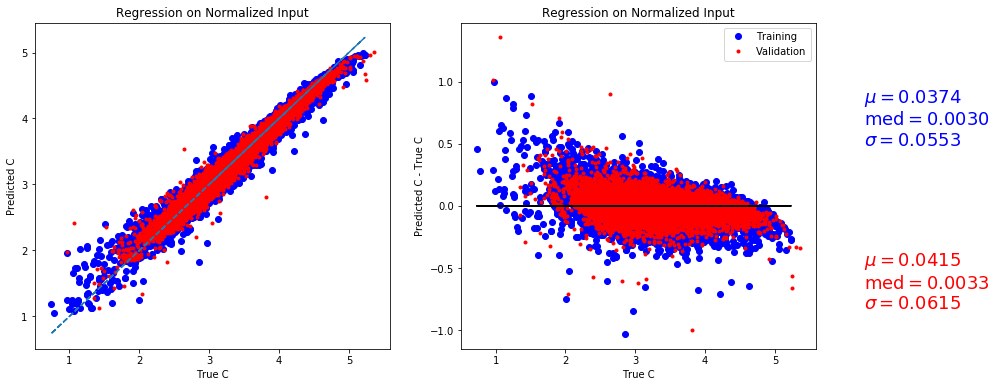

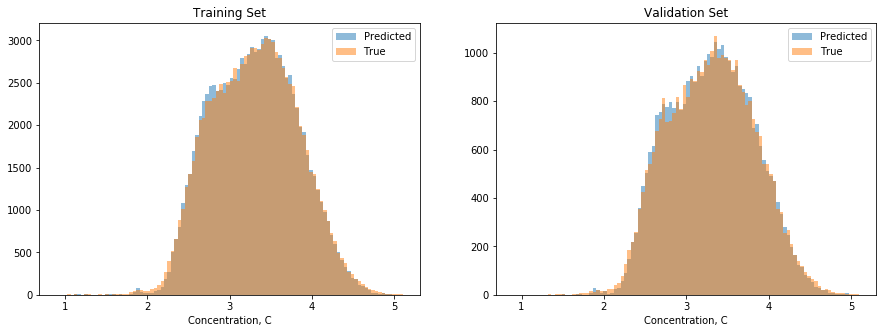

In [17]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=10, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

Feature extraction works really well! The mean difference of validation set improved from 0.08 (see notebook 1) to 0.04 and the $\sigma$ of the validation set improved from 0.11 to 0.06! 

## SGD Regression

In [27]:
from sklearn import linear_model

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


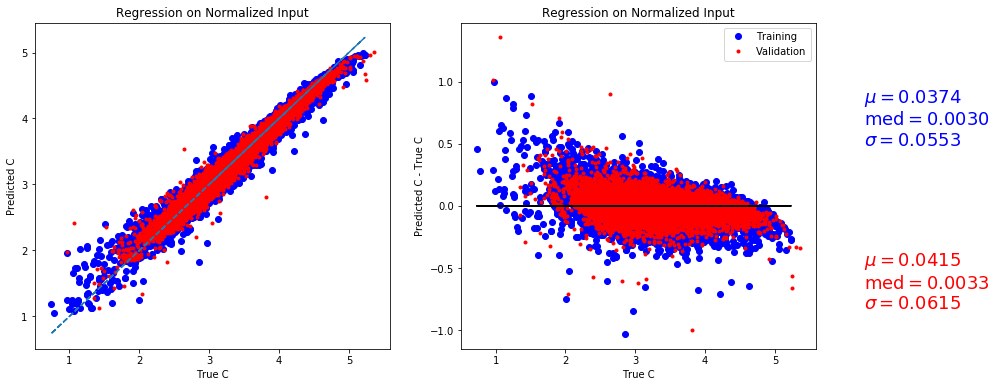

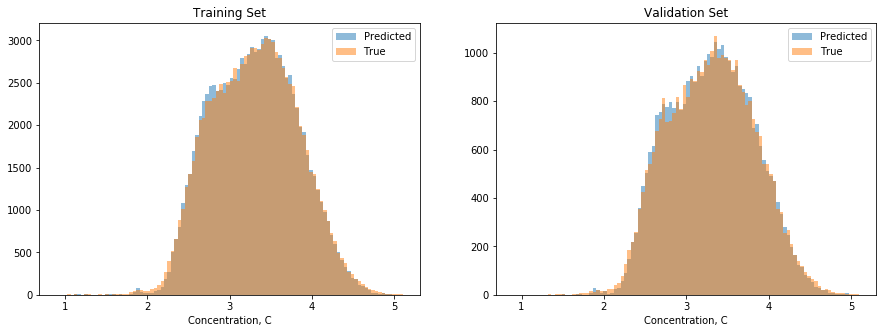

In [29]:
# define hyper parameters
SGD = linear_model.SGDRegressor()

# fit the model with training set
SGD.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

For the SGD regression model, feature extraction improved the mean absolute difference of the validation set from 0.1 (see notebook 2) to 0.04 and the $\sigma$ of the validation set from 0.14 to 0.06!

In [30]:
SGD.coef_

array([-0.0110144 ,  0.00084034,  0.25429987, -0.14074263,  0.00497106,
       -0.06744371,  0.06018867,  0.42477773, -0.12648834,  0.17183641])

The largest coefficient is for the extracted feature $r_{80}/r_{20}$. This explains why the model works so well now.. I'm predicting concentration with..... concentration! 

## Conclusion

By extracting three new features, the models improved their performance by a factor of approximately 2.